## Машинное обучение
## Лабораторная работа №2

    Выполнил студент группы 15-В-2
    Разумовский С.А.
    Вариант №26

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interp
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv(r'iris_data.csv', sep=',')
df.head()

,sl,sw,pl,pw,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
df.shape

(150, 5)

In [4]:
df.count()

sl       150
sw       150
pl       150
pw       150
class    150
dtype: int64

## 1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).


| Переменная   | Описание     | Параметры(Ключи)                       | 
|--------------|--------------|----------------------------------------|
|sl|длина чашелистника в см|любой числовой|
|sw|ширина чашелистника в см|любой числовой|
|pl|длина лепестка в см|любой числовой|
|pw|ширина лепестка в см|любой числовой|
|class|вид|1. Iris Setosa 2. Iris Versicolour 3. Iris Virginica|

**Задача: по данным признакам предсказать класс растения.**

лишних признаков нет

## 2.	Удалите дубликаты строк в наборе данных;


In [5]:
#Duplicates
df = df.drop_duplicates()
df.shape

(147, 5)

In [6]:
df.count()

sl       147
sw       147
pl       147
pw       147
class    147
dtype: int64

## 3.	Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

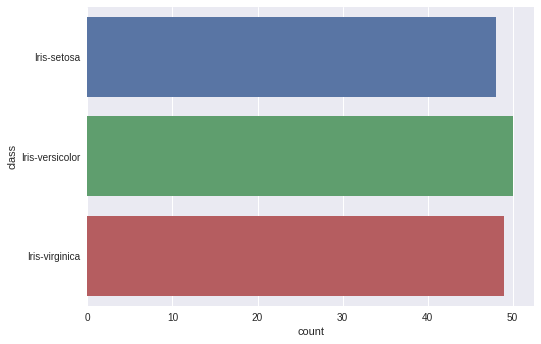

In [7]:
sns.countplot(data=df, y='class')
plt.show()

Соотношение элементов незначительно отличается, считаем, что классы сбалансированны.

## 4.	Выполните масштабирование количественных признаков

In [8]:
# выделим категориальные и числовые(количественные) признаки
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['sl', 'sw', 'pl', 'pw']
categorial:  ['class']


In [9]:
df.head()

,sl,sw,pl,pw,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## 5.	Выполните замену категориальных признаков

In [10]:
lb_make = LabelEncoder() 
df["class"] = lb_make.fit_transform(df["class"])
df.head()

,sl,sw,pl,pw,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## 6.	Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)

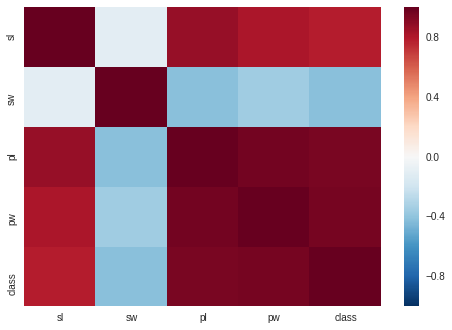

In [11]:
df_corr = df.corr()
sns.heatmap(df_corr)
plt.show()

In [12]:
df_corr

,sl,sw,pl,pw,class
sl,1.000000,-0.109321,0.871305,0.817058,0.782904
sw,-0.109321,1.000000,-0.421057,-0.356376,-0.418348
pl,0.871305,-0.421057,1.000000,0.961883,0.948339
pw,0.817058,-0.356376,0.961883,1.000000,0.955693
class,0.782904,-0.418348,0.948339,0.955693,1.000000


## 7.	Заполните пропущенные значения в данных

Пропущеных значений нет

## 8.	Решите поставленную задачу классификации в соответствии с заданием.

In [109]:
# разделим полученные данные на данные для обучения и теста
X = np.array(df.drop('class', axis=1))
y = np.array(df['class']) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

In [110]:
# найдем оптимальный радиус для классификатора ближайших соседей
rnc = RadiusNeighborsClassifier(outlier_label=3)

params = {'radius': np.arange(0, 10, 0.1)}

rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(X_train, y_train)

best_radius = rnc_grid.best_estimator_.radius
best_score = rnc_grid.best_score_
print('best train score:', best_score, '\t at radius:', best_radius)

rnc = RadiusNeighborsClassifier(outlier_label=3, radius=best_radius)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score: 0.9452054794520548 	 at radius: 1.1
test score:  0.959459459459


In [111]:
#найдем оптимальные глубину и количества учитываемых параметров для классификатора решающее дерево
dtc = DecisionTreeClassifier()

params = {'max_depth': list(range(1,5)), 'max_features': list(range(1,5))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X_train, y_train)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', best_score)
dtc.predict(X_test)

best train score: 0.9726027397260274 	 at features number: 3 	 at depth: 2
test score:  0.945945945946


array([0, 0, 0, 2, 2, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 0, 2,
       1, 2, 0, 2, 1, 1, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 1, 2, 2,
       2, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1, 0, 1, 0,
       2, 2, 0, 2, 2])

In [112]:
from sklearn.metrics import accuracy_score
classifier = RadiusNeighborsClassifier(radius=1.1, n_jobs=-1, outlier_label=3).fit(X_train, y_train)
pred = classifier.predict(X_test)
accuracy_score(y_test, pred)
pred = classifier.radius_neighbors(X_test)[0]
y_test = label_binarize(y_test, classes=[0, 1, 2])
for i in range(len(pred)):
    pred[:][i] = min(pred[:][i]), max(pred[:][i]), np.mean(pred[:][i])
pred[:][73]


(0.38729833462074159, 1.0816653826391966, 0.74176728371601763)

In [113]:
class MyRadiusNeighborsClassifier(RadiusNeighborsClassifier):
        
    def predict_proba(self, X_test, X_train, y_train):
        '''
        
        General description. 
        Determines the probability that a test instance matching a class.
        
        Algorithm. 
        We'll go through the zero radius to the double classifier radius
        with the elementary step(dr). If an instance lies along the:
        * Zero raduis+dr - corresponds 100%
        * Classifier raduis+dr - corresponds 50%
        * Double classifier raduis+dr and beyond it - corresponds 0%
        There are intermediate values of percents. Each step corresponds
        to its own percentage value. If predicted instance changes its 
        class, this instance belongs to the current radius and it is 
        assigned the appropriate percentage. 
        
        fit method built-in
        '''
        runs = 25
        dr = (2*self.radius/runs)    
        
        radiuses = [dr*i for i in range(runs)]  
        percentage = [i/runs for i in range(runs)]
        percentage = sorted(percentage, reverse=True)
        probas = np.ndarray((len(y_test),3), dtype=np.float)
        for i in range(len(probas)):
            probas[i] = [0, 1, 2]
        
        for i, radius in enumerate(radiuses):
            if i==0:
                rnc_temp = RadiusNeighborsClassifier(radius, outlier_label=3)
                predict_first = rnc_temp.fit(X_train, y_train).predict(X_test)
                continue
            else:
                predict_second = predict_first
                rnc_tmp = RadiusNeighborsClassifier(radius, outlier_label=3)
                predict_first = rnc_tmp.fit(X_train, y_train).predict(X_test)
        
            for j, (p1, p2) in enumerate(zip(predict_first, predict_second)):
                if p1!=p2:
                    probas[j,0] = percentage[i]
                    probas[j,1] = 1-probas[j,0]
                
        return probas

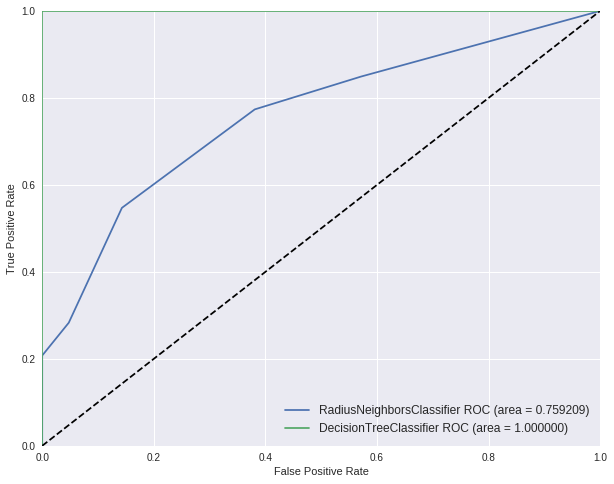

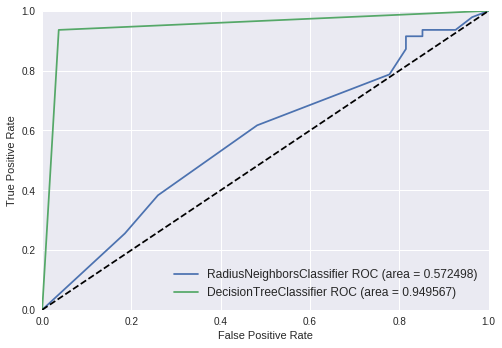

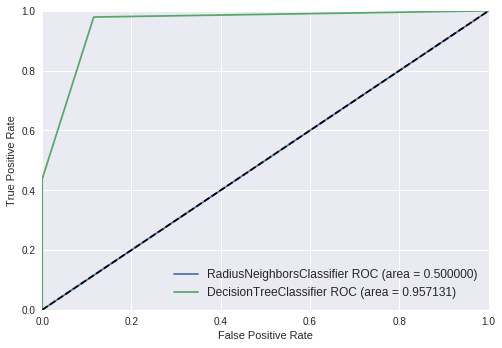

In [117]:
mrnc = MyRadiusNeighborsClassifier(outlier_label=3, radius=best_radius)
probas_mrnc0 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test[:,0], -probas_mrnc0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test[:,0], -probas_dtc0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))  

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.show()

mrnc = MyRadiusNeighborsClassifier(outlier_label=3, radius=best_radius)
probas_mrnc1 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test[:,1], -probas_mrnc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

dtc = DecisionTreeClassifier(max_depth=4, max_features=2)
probas_dtc1 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test[:,1], -probas_dtc0[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))  

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.show()

mrnc = MyRadiusNeighborsClassifier(outlier_label=3, radius=best_radius)
probas_mrnc2 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test[:,2], -probas_mrnc0[:,2])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

dtc = DecisionTreeClassifier(max_depth=4, max_features=2)
probas_dtc2 = dtc.fit(X_train, y_train).predict_proba(X_test)
tpr, fpr, thresholds = roc_curve(y_test[:,2], -probas_dtc0[:,2])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))  

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.show()

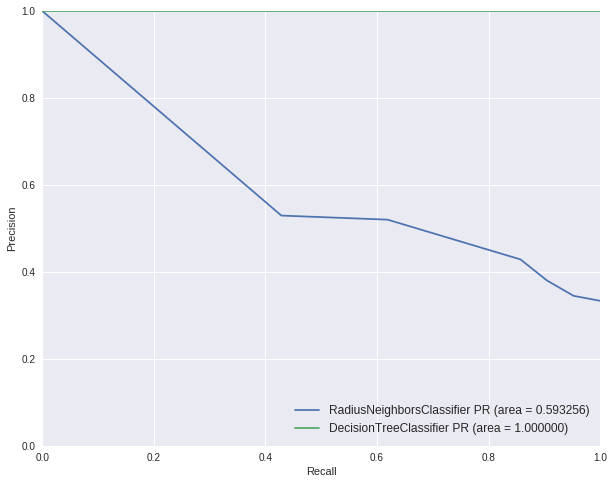

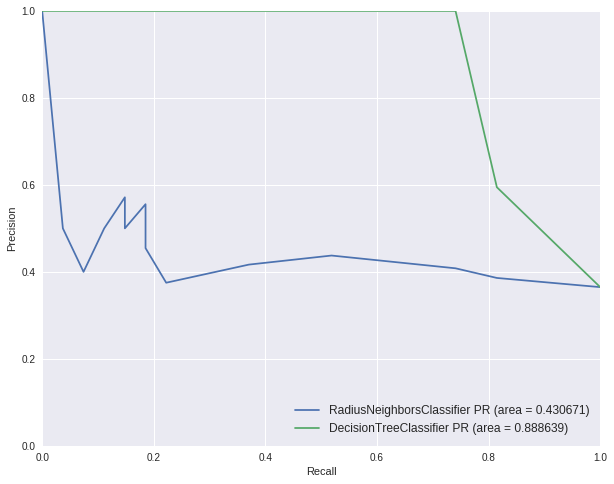

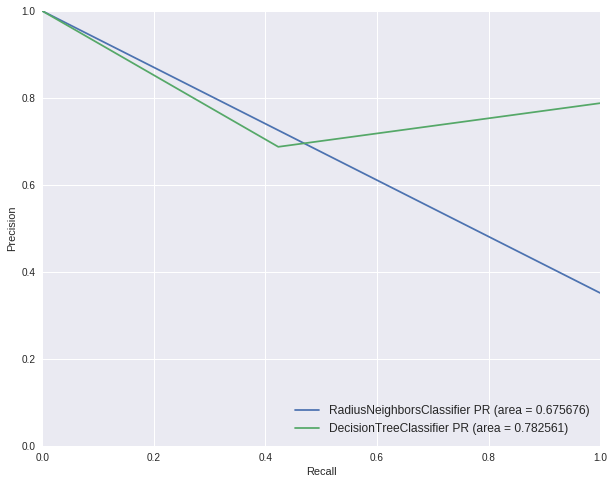

In [133]:
plt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test[:,0], probas_mrnc1[:,0])
aps_mrnc1 = average_precision_score(y_test[:,0],probas_mrnc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test[:,0], probas_dtc1[:,0])
aps_dtc1 = average_precision_score(y_test[:,0],probas_dtc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.show()

plt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test[:,1], probas_mrnc1[:,1])
aps_mrnc1 = average_precision_score(y_test[:,1],probas_mrnc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test[:,1], probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test[:,1],probas_dtc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.show()

plt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test[:,2], probas_mrnc1[:,2])
aps_mrnc1 = average_precision_score(y_test[:,2],probas_mrnc1[:,2])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test[:,2], probas_dtc1[:,2])
aps_dtc1 = average_precision_score(y_test[:,2],probas_dtc1[:,2])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.show()

## 9.	Сравните кривые для классификаторов, указанных в задании, сделайте выводы

Классификаторы дерево принятия решений и k ближайших соседей(по радиусу) имеют примерно одинаковые показатели качества относительно PR и ROC кривых. Данные классификаторы хорошо справляются со своей задачей, так как их точность ≈0.95. Задача классификации была решена.